In [1]:
import pickle
import matplotlib.pyplot as plt
pickle_in = open("dataset_pickle\X.pickle","rb")
X = pickle.load(pickle_in)

X = X/255.0

pickle_in = open("dataset_pickle\y.pickle","rb")
y = pickle.load(pickle_in)

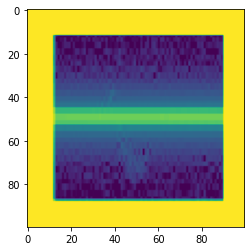

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
plt.imshow(x_train[0])

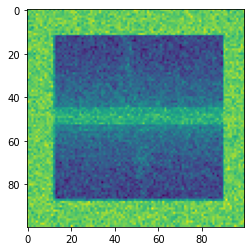

In [59]:
#Double dataset with Gaussian Noise
from tensorflow.keras.layers import GaussianNoise

sample = GaussianNoise(0.1)
sample2 = GaussianNoise(0.1)
noise_train = sample(X,training = True)
plt.imshow(noise_train[89])


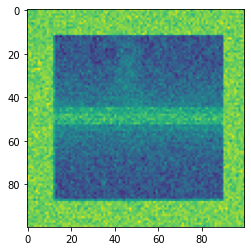

In [45]:
plt.imshow(noise_test[5])

In [60]:
X = X + noise_train


In [61]:
#Setup Distrbuited training
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())   #Enables

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras import regularizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard
from sklearn.model_selection import StratifiedKFold #for K-fold cross validation
import numpy

tf.random.set_seed(42)

Resolution = 100

# numpy.random.seed(7)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
cvscores = []

#for train, test in kfold.split(X, y):

with strategy.scope():      #Enables multi-gpu
    model = Sequential([
        
        Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu', input_shape=(Resolution, Resolution, 1)),
        MaxPooling2D(pool_size=(1, 5), strides=(4)),

        Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
        MaxPooling2D(pool_size=(1, 4), strides=(2)),

        Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
        MaxPooling2D(pool_size=(1, 2), strides=(2)),

        Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=(2)),

        Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
        MaxPooling2D(pool_size=(1, 2), strides=(2)),
        
        Flatten(),
        #Dense(32, activation='relu'),

        Dense(6, activation='softmax')
    ])


model.summary()

model.compile(loss='sparse_categorical_crossentropy',
            optimizer=optimizers.Adam(learning_rate=0.001),                  #gradient descent
            metrics=['accuracy'])
            

lr_change = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=0.000)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, mode='min')
callbacks = [lr_change,early_stopping]
    #scores = model.evaluate(X[test], y[test], verbose=0)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #cvscores.append(scores[1] * 100)
#print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 25, 24, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 25, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 11, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 13, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 5, 32)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 5, 32)         

In [63]:
history = model.fit(X, y, batch_size=16, epochs=200, validation_split=0.2,callbacks=callbacks)
#history = model.fit(x_train, y_train, batch_size=16, epochs=200, validation_data=(x_test,y_test),callbacks=callbacks)

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = hierarchical_copy, num_packs = 1


UnknownError: 3 root error(s) found.
  (0) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_3/conv2d_15/Conv2D (defined at c:\users\admin-group11\appdata\local\programs\python\python38\lib\threading.py:932) ]]
	 [[div_no_nan_1/ReadVariableOp_1/_28]]
  (1) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_3/conv2d_15/Conv2D (defined at c:\users\admin-group11\appdata\local\programs\python\python38\lib\threading.py:932) ]]
  (2) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_3/conv2d_15/Conv2D (defined at c:\users\admin-group11\appdata\local\programs\python\python38\lib\threading.py:932) ]]
	 [[update_0/AssignAddVariableOp/_51]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_7653]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_3/conv2d_15/Conv2D:
 IteratorGetNext (defined at <ipython-input-63-a207b7cb01ff>:1)

Input Source operations connected to node sequential_3/conv2d_15/Conv2D:
 IteratorGetNext (defined at <ipython-input-63-a207b7cb01ff>:1)

Input Source operations connected to node sequential_3/conv2d_15/Conv2D:
 IteratorGetNext (defined at <ipython-input-63-a207b7cb01ff>:1)

Function call stack:
train_function -> train_function -> train_function


In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X,  y, verbose=2)
preds = model.evaluate(X, y,verbose=1, sample_weight=None)

In [ ]:
model.save("models\model_habd2.h5")
print("model saved")

In [ ]:
from keras.models import load_model
# load model
model = load_model('models\model_habd.h5')

In [ ]:
# evaluate the model
import pickle
pickle_in = open("dataset_pickle\X_user.pickle","rb")
X_test = pickle.load(pickle_in)

pickle_in = open("dataset_pickle\y_user.pickle","rb")
y_test = pickle.load(pickle_in)

X_test = X_test/255.0

score = model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))